In [ ]:
#upload data from kaggle using API token
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#download dataset (Genius Song Lyrics)
!kaggle datasets download -d carlosgdcj/genius-song-lyrics-with-language-information

Dataset URL: https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information
License(s): unknown
100% 3.03G/3.04G [00:50<00:00, 35.1MB/s]
100% 3.04G/3.04G [00:50<00:00, 64.4MB/s]


In [ ]:
#necessary imports/installations
import zipfile
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
#unzip the dataset to access the CSV file
with zipfile.ZipFile('genius-song-lyrics-with-language-information.zip', 'r') as zip_ref:
    zip_ref.extractall('lyrics_data')

In [ ]:
#filter dataset (including only artist and lyrics columns, for our 6 chosen artists)

#selected artists
artists = [
    "taylor swift", "drake", "kendrick lamar",
    "bad bunny", "billie eilish", "the weeknd"
]
artists_lower = [a.lower() for a in artists]
#process chunks of the dataset at a time to avoid consuming RAM (100,000 rows per chunk)
chunksize = 100_000
filtered_rows = []
#add filtered rows for all chunks
for chunk in pd.read_csv('/content/lyrics_data/song_lyrics.csv', chunksize=chunksize, usecols=['artist', 'lyrics']):
    chunk['artist_clean'] = chunk['artist'].str.lower().str.strip()
    filtered = chunk[chunk['artist_clean'].isin(artists_lower)]
    filtered_rows.append(filtered)
#combine all filtered chunks into one dataframe
df = pd.concat(filtered_rows, ignore_index=True)
display(df)

,artist,lyrics,artist_clean
0,Drake,"[Intro: Lil Wayne]\nYeah\nUh-huh\nUm, uh-huh\n...",drake
1,Drake,[Verse 1]\nUh\nI'm just so far gone\nOctober's...,drake
2,Drake,[Produced by Boi-1da and Nick Brongers]\n\n[In...,drake
3,Drake,[Hook]\nI'm still fly I'm sky high and I dare ...,drake
4,Drake,"[Intro: Trey Songz]\nThe money (Money), cars (...",drake
...,...,...,...
2088,The Weeknd,[Chorus: The Weeknd]\nAh-ah-ah-ah-ah\nAnother ...,the weeknd
2089,Taylor Swift,[Verse 1]\nI'm so glad you made time to see me...,taylor swift
2090,Taylor Swift,[Verse 1]\nYou and I walk a fragile line\nI ha...,taylor swift
2091,Taylor Swift,"[Verse 1]\nI used to think one day, we'd tell ...",taylor swift


In [ ]:
#display number of songs per artist in dataset
df['artist_clean'].value_counts()

,count
artist_clean,
drake,558
taylor swift,543
kendrick lamar,349
the weeknd,306
billie eilish,221
bad bunny,116


In [ ]:
#split lyrics into short text units using NLTK
df['sentences'] = df['lyrics'].apply(nltk.sent_tokenize)
exploded = df.explode('sentences')
#remove extremely short sentences
exploded = exploded[exploded['sentences'].str.len() > 10]
exploded.reset_index(drop=True, inplace=True)
exploded.head()

,artist,lyrics,artist_clean,sentences
0,Drake,"[Intro: Lil Wayne]\nYeah\nUh-huh\nUm, uh-huh\n...",drake,"[Intro: Lil Wayne]\nYeah\nUh-huh\nUm, uh-huh\n..."
1,Drake,"[Intro: Lil Wayne]\nYeah\nUh-huh\nUm, uh-huh\n...",drake,"It's Weezy F Baby, come to take a shit and uri..."
2,Drake,"[Intro: Lil Wayne]\nYeah\nUh-huh\nUm, uh-huh\n...",drake,"She said ""I can't feel my legs"", I'm like ""Bit..."
3,Drake,"[Intro: Lil Wayne]\nYeah\nUh-huh\nUm, uh-huh\n...",drake,"I don't even know, maybe where my blunt ends\n..."
4,Drake,"[Intro: Lil Wayne]\nYeah\nUh-huh\nUm, uh-huh\n...",drake,"Bitch, I said I'm him, so I'm nothin' like the..."


In [ ]:
#embed sentences with Sentence-BERT
model = SentenceTransformer("all-mpnet-base-v2")
#compute embeddings
sentences = exploded['sentences'].tolist()
#batch encoding process for better memory usage
embeddings = model.encode(
    sentences,
    batch_size=64,
    show_progress_bar=True
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/211 [00:00<?, ?it/s]

In [ ]:
#cluster sentences using k-means clustering
k = 12
kmeans = KMeans(n_clusters=k, random_state=42)
exploded['cluster'] = kmeans.fit_predict(embeddings)

In [ ]:
#use TF-IDF to explore each cluster
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf = vectorizer.fit_transform(exploded['sentences'])
terms = vectorizer.get_feature_names_out()
#identify top ten most important key words per cluster
def top_keywords(cluster_id, n=10):
    idx = exploded['cluster'] == cluster_id
    cluster_tfidf = tfidf[idx.values].mean(axis=0)
    top_indices = cluster_tfidf.A1.argsort()[-n:][::-1]
    return [terms[i] for i in top_indices]
#display words per cluster
for c in range(k):
    print(f"Cluster {c}: {top_keywords(c)}")

Cluster 0: ['love', 'don', 'know', 'baby', 'want', 'fancy', 'huh', 'oh', 'just', 'girl']
Cluster 1: ['verse', 'chorus', 'oh', 'know', 'love', 'don', 'like', 've', 'say', 'just']
Cluster 2: ['know', 'woods', 'clear', 'yeah', 'right', 'just', 'did', 'like', 'okay', 'good']
Cluster 3: ['que', 'la', 'el', 'yo', 'en', 'te', 'lo', 'ey', 'tú', 'yeh']
Cluster 4: ['nigga', 'like', 'got', 'niggas', 'shit', 'know', 'fuck', 'bitch', 'man', 'don']
Cluster 5: ['hidden', 'message', 'tesfaye', 'love', 'thank', 'like', 'says', 'know', '11', 'taylor']
Cluster 6: ['like', 'just', 'feel', 'know', 'don', 'people', 'life', 'say', 've', 'things']
Cluster 7: ['music', 'album', 'like', 'kendrick', 'songs', 'just', 'song', 'know', 'people', 'artists']
Cluster 8: ['want', 'ah', 'love', 'wanna', 'intro', 'yeah', 'drake', 'man', 'don', 'got']
Cluster 9: ['ft', 'drake', 'weeknd', 'lil', 'remix', 'partynextdoor', 'feat', 'set', 'new', 'future']
Cluster 10: ['like', 'know', 'got', 'yeah', 'don', 'drake', 'verse', 'sh

In [ ]:
#manually label clusters as themes
theme_map = {
    0: "Love", #'love', 'baby', 'girl'
    1: "Musical/Lyrical Structure", #words like verse and chorus
    2: "Introspection", #'know', 'clear', 'right'
    3: "General Spanish Phrases",
    4: "Aggression", #cuss words
    5: "Shout-outs and references", #'thank', 'message'
    6: "Emotions", #'feel', 'life'
    7: "Music Industry", #'music', 'album', 'songs'
    8: "Desire", #'want', 'love'
    9: "Music Artists/Features", #mentions all artists names
    10: "Confidence", #some explicit content/artists referencing themselves
    11: "Romance" #verse, baby, love
}
exploded['theme'] = exploded['cluster'].map(theme_map)


In [ ]:
#compute theme percentages per artist - song level
exploded['song_id'] = exploded.groupby(['artist_clean', 'lyrics']).ngroup()
song_themes = exploded.groupby('song_id').agg({
    'artist_clean': 'first',
    'theme': lambda x: x.value_counts().idxmax()  # most common theme in the song
}).reset_index()
#count songs per artist per theme
song_theme_counts = song_themes.groupby(['artist_clean', 'theme']).size().reset_index(name='count')
# total songs per artist
total_songs = song_themes.groupby('artist_clean').size().reset_index(name='total')
#compute percentage of songs per theme
song_theme_percent = song_theme_counts.merge(total_songs, on='artist_clean')
song_theme_percent['percentage'] = song_theme_percent['count'] / song_theme_percent['total']
#display
song_theme_percent


,artist_clean,theme,count,total,percentage
0,bad bunny,General Spanish Phrases,115,116,0.991379
1,bad bunny,Shout-outs and references,1,116,0.008621
2,billie eilish,Confidence,6,213,0.028169
3,billie eilish,Emotions,17,213,0.079812
4,billie eilish,General Spanish Phrases,1,213,0.004695
5,billie eilish,Introspection,10,213,0.046948
6,billie eilish,Love,15,213,0.070423
7,billie eilish,Music Artists/Features,3,213,0.014085
8,billie eilish,Music Industry,4,213,0.018779
9,billie eilish,Musical/Lyrical Structure,55,213,0.258216


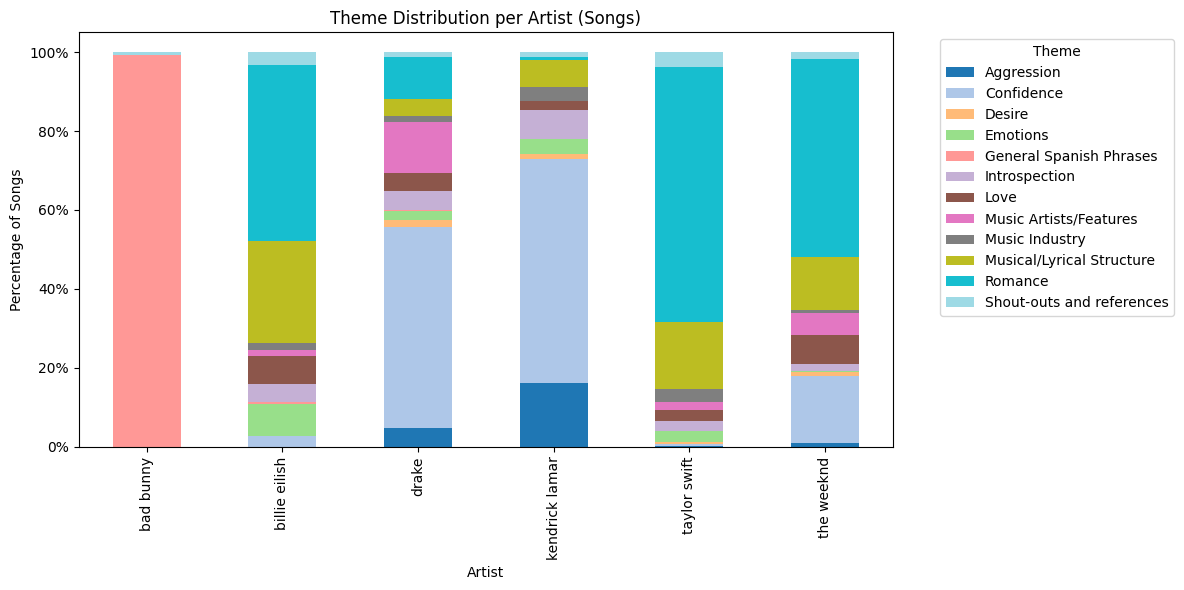

In [ ]:
#plot percentages per artist shown in a stacked bar chart (where each song is marked as a certain theme)
theme_wide_songs = song_theme_percent.pivot(index='artist_clean', columns='theme', values='percentage').fillna(0)
theme_wide_songs.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.ylabel('Percentage of Songs')
plt.xlabel('Artist')
plt.title('Theme Distribution per Artist (Songs)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

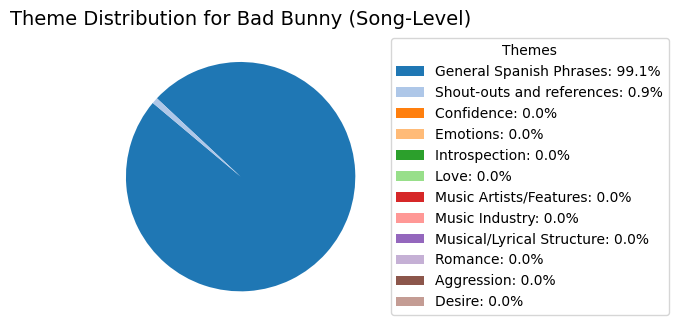

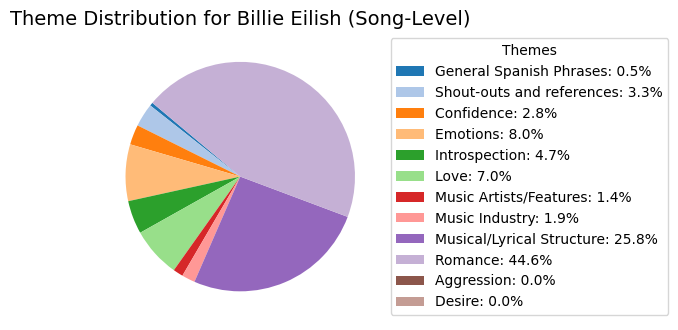

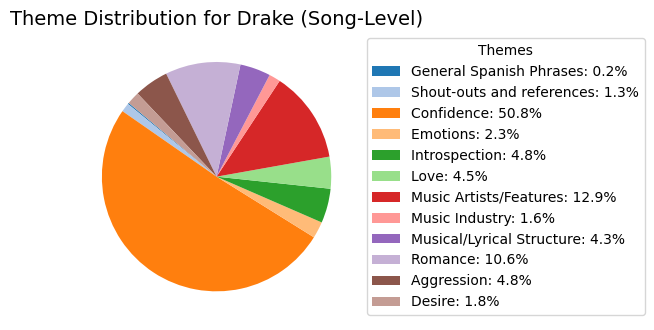

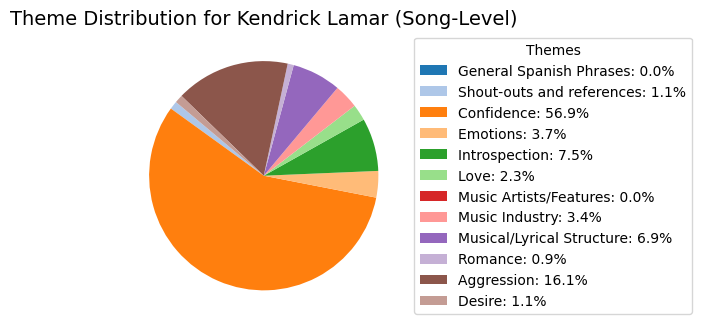

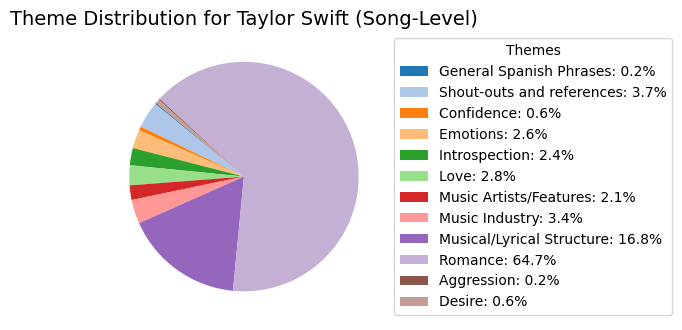

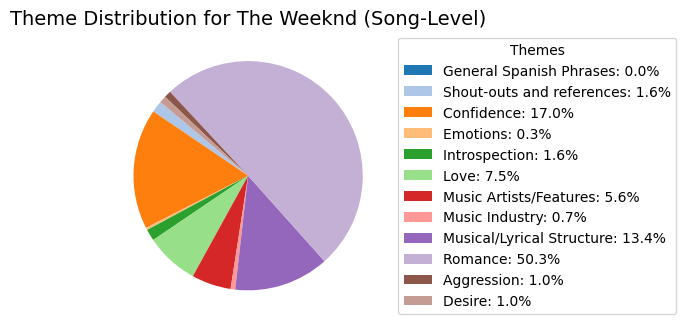

In [ ]:
#plot song percentages per artist shown in individual pie charts
themes = song_theme_percent['theme'].unique()
colors = plt.get_cmap('tab20').colors[:len(themes)]
color_map = dict(zip(themes, colors))
for artist in song_theme_percent['artist_clean'].unique():
    data = song_theme_percent[song_theme_percent['artist_clean'] == artist]
    data = data.set_index('theme').reindex(themes, fill_value=0).reset_index()
    #legend includes themes and percentages
    legend_labels = [f"{t}: {p:.1%}" for t, p in zip(data['theme'], data['percentage'])]
    plt.figure(figsize=(6,6))
    plt.pie(data['percentage'], colors=[color_map[t] for t in data['theme']], startangle=140)
    plt.title(f'Theme Distribution for {artist.title()} (Song-Level)', fontsize=14)
    plt.legend(legend_labels, title="Themes", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.tight_layout()
    plt.show()

In [ ]:
#different approach - artist's percentage of theme = num of sentences in that theme/total num of sentences for that artist
theme_counts = exploded.groupby(['artist_clean', 'theme']).size().reset_index(name='count')
theme_counts['percentage'] = theme_counts.groupby('artist_clean')['count'].transform(lambda x: x / x.sum())
theme_percent = theme_counts
theme_percent

,artist_clean,theme,count,percentage
0,bad bunny,Aggression,5,0.008052
1,bad bunny,Confidence,2,0.003221
2,bad bunny,Desire,5,0.008052
3,bad bunny,General Spanish Phrases,599,0.964573
4,bad bunny,Introspection,2,0.003221
...,...,...,...,...
62,the weeknd,Music Artists/Features,230,0.133799
63,the weeknd,Music Industry,106,0.061664
64,the weeknd,Musical/Lyrical Structure,197,0.114602
65,the weeknd,Romance,288,0.167539


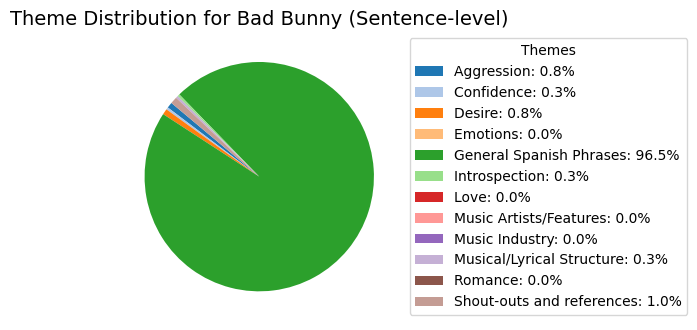

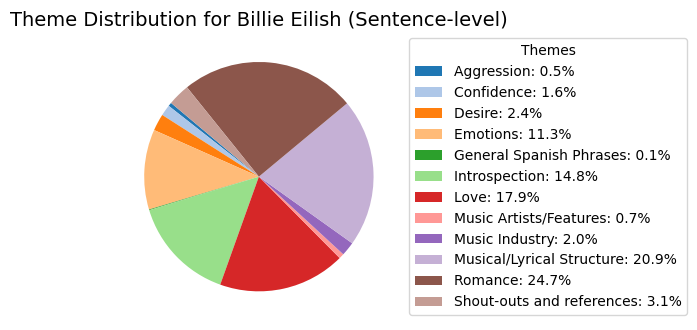

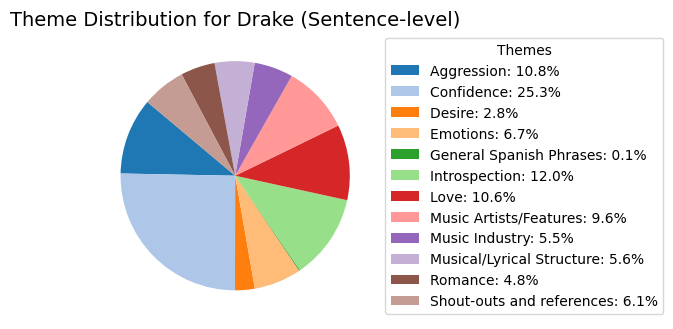

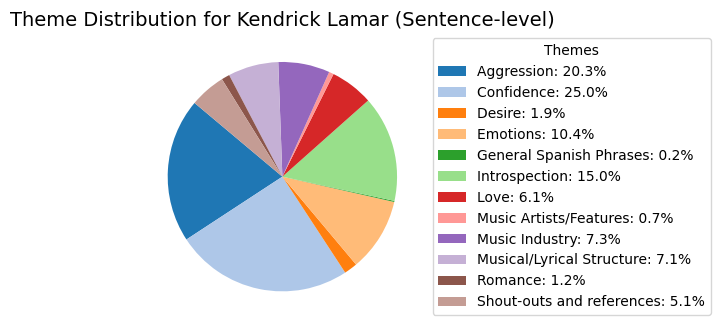

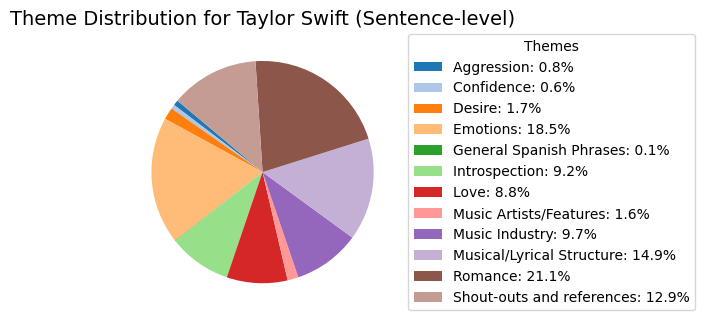

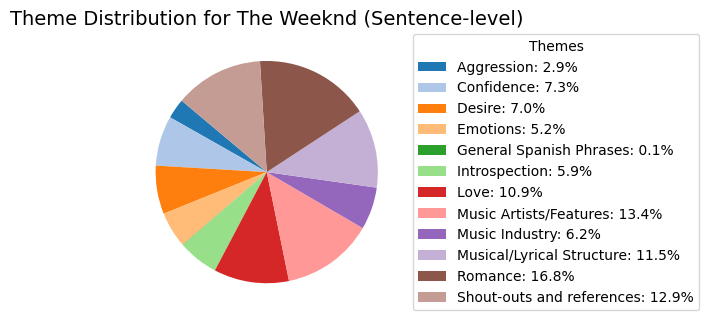

In [ ]:
#individual pie charts for percentages by artist (using sentences instead of songs)
themes = sorted(theme_percent['theme'].dropna().unique())
colors = plt.get_cmap('tab20').colors[:len(themes)]
color_map = dict(zip(themes, colors))
for artist in sorted(theme_percent['artist_clean'].dropna().unique()):
    data = theme_percent[theme_percent['artist_clean'] == artist].copy()
    data = data.set_index('theme').reindex(themes, fill_value=0).reset_index()
    legend_labels = [f"{t}: {p:.1%}" for t, p in zip(data['theme'], data['percentage'])]
    plt.figure(figsize=(6, 6))
    plt.pie(data['percentage'], colors=[color_map[t] for t in data['theme']], startangle=140)
    plt.title(f"Theme Distribution for {artist.title()} (Sentence-level)", fontsize=14)
    plt.legend(legend_labels, title="Themes", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.tight_layout()
    plt.show()


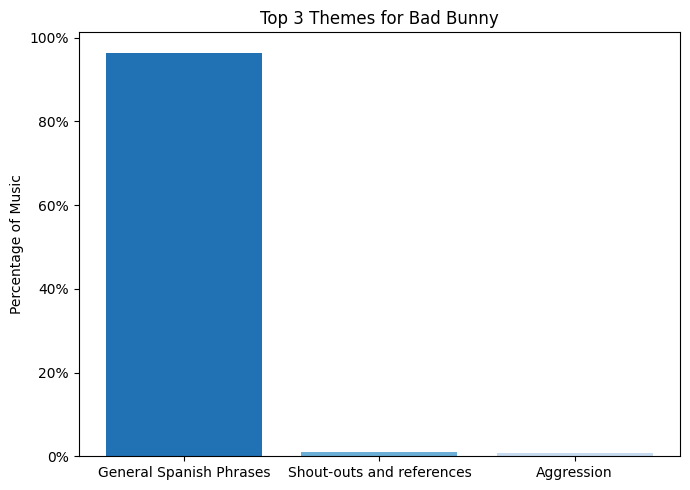

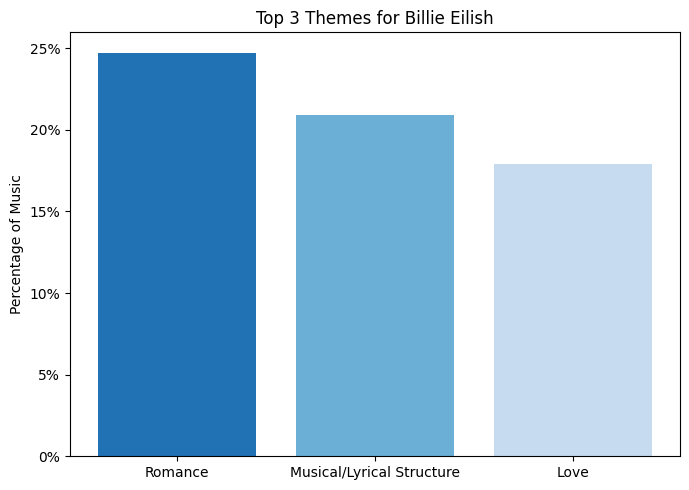

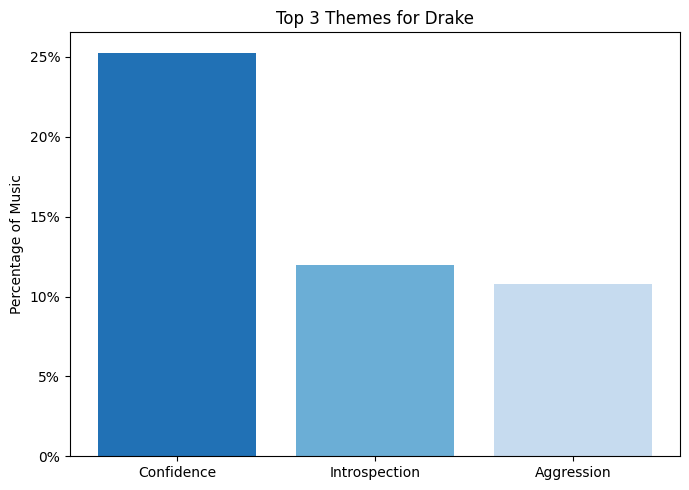

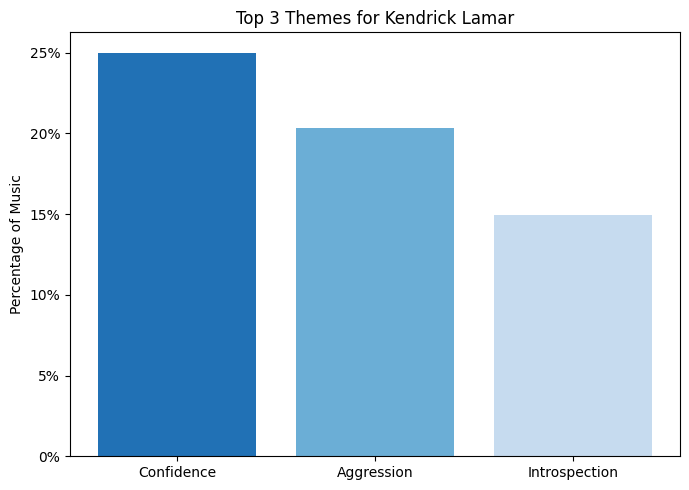

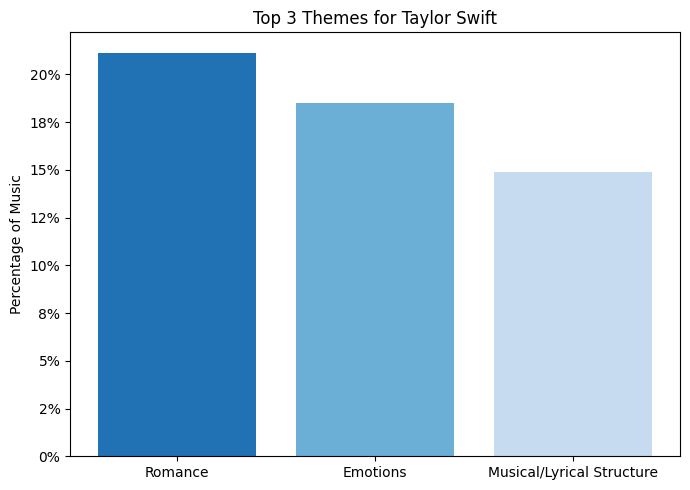

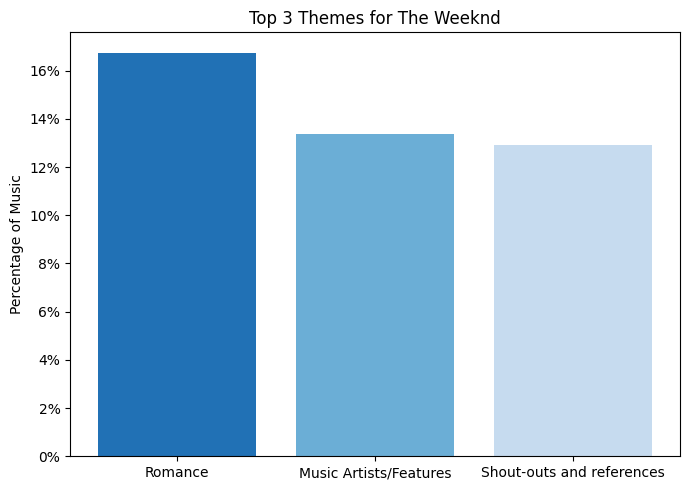

In [ ]:
#bar graphs for most common themes among artists (each artist's top three themes)
colors = ["#2171b5", "#6baed6", "#c6dbef"]
theme_percent = theme_percent.copy()
theme_percent['rank'] = theme_percent.groupby('artist_clean')['percentage'].rank(method='first', ascending=False)
#get top three themes
top3 = theme_percent[theme_percent['rank'] <= 3]
artists = top3['artist_clean'].unique()
for artist in artists:
    data = top3[top3['artist_clean'] == artist].sort_values('percentage', ascending=False)
    plt.figure(figsize=(7,5))
    plt.bar(data['theme'], data['percentage'], color=colors)
    plt.ylabel("Percentage of Music")
    plt.title(f"Top 3 Themes for {artist.title()}")
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
    plt.tight_layout()
    plt.show()